<a href="https://colab.research.google.com/github/mehdig110/PythonFirstAttempt/blob/main/LSTM_MODFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive/
<class 'pandas.core.series.Series'>
RangeIndex: 133 entries, 0 to 132
Series name: GWD_T360_ft
Non-Null Count  Dtype  
--------------  -----  
133 non-null    float64
dtypes: float64(1)
memory usage: 1.2 KB


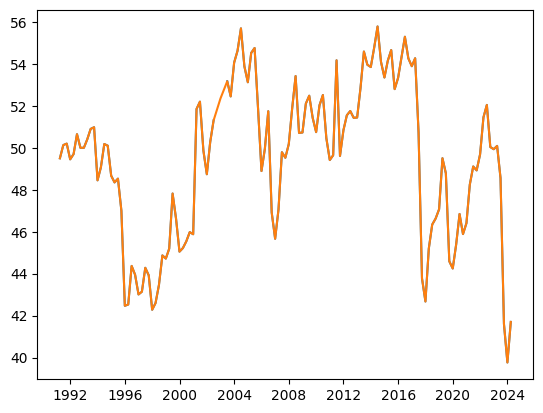

In [26]:
from google.colab import drive
drive.mount('/content/drive/')
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
# os.getcwd()
# list(df)


quarter= '/content/drive/MyDrive/Colab Notebooks/Quarterly.xlsx'
Quarterly=pd.read_excel(quarter)
Quarterly.columns
plt.plot(Quarterly['time'],Quarterly['GWD_T360_ft'])
DTW= Quarterly['GWD_T360_ft']
DTW_Interpolated= Quarterly['GWD_T360_ft'].interpolate()
DTW_Interpolated.info()
plt.plot(Quarterly['time'],DTW_Interpolated)


In [27]:
# [[[1], [2], [3], [4]]] [5]
# [[[2], [3], [4], [5]]] [6]
# [[[3], [4], [5], [6]]] [7]

def df_to_X_y(df, window_size=4):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [28]:
WINDOW_SIZE = 8
X1, y1 = df_to_X_y(DTW_Interpolated, WINDOW_SIZE)
X1.shape, y1.shape
X1[-2:]

array([[[49.69      ],
        [51.45333333],
        [52.045     ],
        [50.03666667],
        [49.93333333],
        [50.09      ],
        [48.56      ],
        [41.60333333]],

       [[51.45333333],
        [52.045     ],
        [50.03666667],
        [49.93333333],
        [50.09      ],
        [48.56      ],
        [41.60333333],
        [39.76666667]]])

In [29]:
X_train1, y_train1 = X1[:91], y1[:91]
X_val1, y_val1 = X1[91:101], y1[91:101]
X_test1, y_test1 = X1[101:], y1[101:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((91, 8, 1), (91,), (10, 8, 1), (10,), (24, 8, 1), (24,))

In [ ]:
# # prompt: implement keras LSTM without sequential layers

# inputs = tf.keras.Input(shape=(WINDOW_SIZE, 1))
# lstm, h, c = tf.keras.layers.LSTM(4, return_sequences=False, return_state = True)(inputs)
# outputs = tf.keras.layers.Dense(4)(lstm)
# outputs = tf.keras.layers.Dense(1)(outputs)
# model1 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# model1.summary()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1))) # timestamp , numfeatures
# model1.add(InputLayer((1, 4)))
# model1.add(Flatten())
# model1.add(LSTM(4, return_sequences = True, activation="tanh", kernel_initializer="glorot_uniform", dropout=0.1))
model1.add(LSTM(64))
#, return_sequences = False, return_state = False, activation="relu", kernel_initializer="glorot_uniform", dropout=0.4))
#model1.add(BatchNormalization())
model1.add(Dense(64, activation='relu'))
#model1.add(Dropout(0.2))
model1.add(Dense(1, activation='linear'))

model1.summary()

In [31]:
cp1 = ModelCheckpoint('model1', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [ ]:
X_train1 = X_train1.reshape((X_train1.shape[0], X_train1.shape[1], 1))
X_val1 = X_val1.reshape((X_val1.shape[0], X_val1.shape[1], 1))
X_test1 = X_test1.reshape((X_test1.shape[0], X_test1.shape[1], 1))
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), batch_size=16, epochs=200, callbacks=[cp1])

In [40]:
from tensorflow.keras.models import load_model
model1 = load_model('model1')

In [44]:
train_predictions = model1.predict(X_train1).flatten()
test_predictions = model1.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})


1/1 [==============================] - 0s 19ms/step


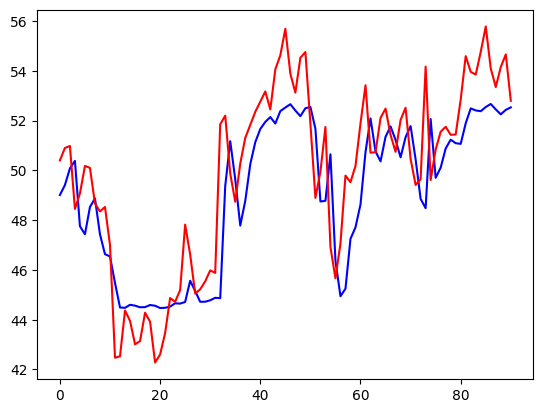

In [42]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], 'b')
plt.plot(train_results['Actuals'], 'r')

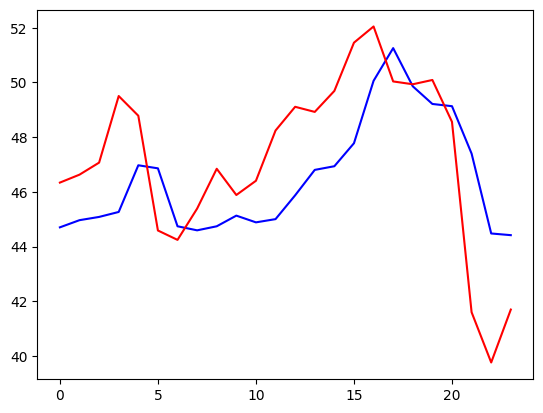

In [43]:

plt.plot(test_results['Test Predictions'], 'b')
plt.plot(test_results['Actuals'], 'r')

In [ ]:
import numpy as np
print("Root-mean-squared error: ", np.sqrt(np.mean((test_results['Test Predictions'].values - test_results['Actuals'].values)**2)))
# print("Square-error: ", sum((test_results['Test Predictions'].values - test_results['Actuals'].values)**2) / len(test_results['Actuals'].values) )

Root-mean-squared error:  2.2335728490373543


In [ ]:
# base model: value at time t is the prediction at time t+1.
print("Root-mean-squared error: ", np.sqrt(np.mean((test_results['Test Predictions'].values[1:] - test_results['Actuals'].values[:-1])**2)))

Root-mean-squared error:  1.1052599282897877


In [ ]:
train_results.info()

In [ ]:
## finding the lag where the maximum correlation happens
cross_corr= np.correlate(train_results['Actuals'], train_results['Train Predictions'], mode='full')
lags = np.arange(-len(train_results['Actuals']) + 1, len(train_results['Actuals']))
max_corr_index = np.argmax(cross_corr)
max_corr = cross_corr[max_corr_index]
lag_at_max_corr = lags[max_corr_index]

print(f"Maximum correlation: {max_corr} at lag {lag_at_max_corr}")

# Plot the cross-correlation
# plt.figure(figsize=(10, 6))
 plt.plot(lags, cross_corr)

IndentationError: unexpected indent (<ipython-input-16-d199816213fd>, line 12)

In [ ]:
help(np.argmax)




In [ ]:
# prompt: apply a time series decomposition on DTW_Interpolated

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(DTW_Interpolated, period=12, model='additive')

# Plot the decomposed components
plt.style.use('ggplot')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot the trend component
decomposed.trend.plot(ax=ax1)
ax1.set_title('Trend Component')

# Plot the seasonal component
decomposed.seasonal.plot(ax=ax2)
ax2.set_title('Seasonal Component')

# Plot the residual component
decomposed.resid.plot(ax=ax3)
ax3.set_title('Residual Component')

plt.tight_layout()
plt.show()


NameError: name 'DTW_Interpolated' is not defined

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate a sample time series
np.random.seed(0)
time_series = np.sin(np.arange(0, 100, 0.1)) + np.random.normal(0, 0.1, 1000)
plt.plot(time_series)
plt.show()
df = pd.DataFrame(time_series, columns=['value'])

# Function to create sequences
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 10
X, y = create_sequences(df['value'].values, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape
X_train[791]
# help(train_test_split)

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Predict on the test set
y_pred = model.predict(X_test)

# Flatten the predictions and actual values for plotting
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Create a sequence of indices to match the length of y_test
test_indices = np.arange(len(y_train), len(y_train) + len(y_test))

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_indices, y_test_flat, label='Actual')
plt.plot(test_indices, y_pred_flat, label='Predicted', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


10